Se deben generar 5 robots como Roombas, que limpien una oficina y cada una tiene capacidad de 5 unidades de basura. Al inicio, se debe ingresar un .txt con las dimensiones de la sala (5<=x<=50) y después se dará el mapeo, EJ:


4 4  
S 0 X 3  
1 2 7 X  
2 X 2 2  
0 0 0 P  


6 5  
S 4 0 6 0   
6 X 0 X 4  
0 X 7 X 0  
5 0 0 X 8  
0 0 X 0 0  
0 0 0 0 P  

Los espacios en los que hay una X, son espacios inaccesibles, P es la papelera y S es el punto de partida de los robots. Los robots no pueden conocer el mapa, solo pueden conocer la ubicación de la papelera. Los robots deberán explorar y recoger las unidades de basura que puedan, en caso de requerir ayuda, pueden solicitar ayuda a los demás robots. Cabe destacar que los robots no pueden saber nada del mapa a excepción de lo que se mapea, en caso de que los robots muestren que saben donde hay basura, se penalizarán por 50 puntos.

Los robots son capaces de ver y dar a conocer a los demás robots solo los bloques con los que estén colindando. Solo puede saber a su alrededor si hay obstáculos, otro robot o basura, más no puede saber cuanta basura hay hasta que está en ese espacio.   
EJ:

? ? ? ? ? ? ? ?  
? ? ? B B B ? ?  
? ? ? B R B ? ?  
? ? ? B B X ? ?  
? ? ? ? ? ? ? ?  



Si tienes alguna duda, habla con el profesor o revisa el repo de la clase.


In [409]:
# PARA COLAB SOLAMENTE O ENTORNOS EXTERNOS
# !pip install mesa scikit-learn numpy pandas matplotlib networkx

In [410]:
# Imports
from mesa import Agent, Model
from mesa.time import RandomActivation
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import heapq
import random
%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128
import pandas as pd
from mesa.datacollection import DataCollector
from IPython.display import HTML
import heapq
import numpy as np
import networkx as nx

In [411]:
def leer_mapa(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
        mapaREAL = [list(line.replace(" ", "").strip()) for line in lines[1:]]

    filas = len(mapaREAL)
    columnas = len(mapaREAL[0])

    mapaUNKNOWN = [fila[:] for fila in mapaREAL]  # Crear una copia de mapaREAL

    for i in range(filas):
        for j in range(columnas):
            if mapaREAL[i][j] not in ['S', 'P']:
                mapaUNKNOWN[i][j] = '?'

    return mapaREAL, mapaUNKNOWN

def construir_grafo(mapa):
    grafo = {}
    filas = len(mapa)
    columnas = len(mapa[0])

    for i in range(filas):
        for j in range(columnas):
            if mapa[i][j] != 'X':
                nodo = (i, j)
                vecinos = []

                if i - 1 >= 0 and mapa[i-1][j] != 'X': vecinos.append((i-1, j))
                if i + 1 < filas and mapa[i+1][j] != 'X': vecinos.append((i+1, j))
                if j - 1 >= 0 and mapa[i][j-1] != 'X': vecinos.append((i, j-1))
                if j + 1 < columnas and mapa[i][j+1] != 'X': vecinos.append((i, j+1))

                if len(vecinos) > 0:
                    grafo[nodo] = vecinos
                else:
                    print(f'El nodo {nodo} no es accesible')

    return grafo

In [412]:
# Se definen algoritmos

def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

# Implementación del algoritmo A*
def a_star_search(graph, start, goal):
    frontier = []
    heapq.heappush(frontier, (0, start))
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0

    # if not graph[goal]:
    #     print("Nodo inaccesible identificado!")
    #     return graph

    while frontier:
        _, current = heapq.heappop(frontier)
        if current == goal:
            break
        for next in graph[current]:
            new_cost = cost_so_far[current] + 1
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost + heuristic(goal, next)
                heapq.heappush(frontier, (priority, next))
                came_from[next] = current

    # Reconstruct path
    current = goal
    path = []
    while current != start:
        path.append(current)
        current = came_from[current]
    path.append(start)
    path.reverse()
    return path
    

In [413]:
# Definición de Agentes

class Robot(Agent):
    def __init__(self, unique_id, model, inicio):
        super().__init__(unique_id, model)
        self.posicion = inicio
        self.capacidad = 5
        self.mapeoIniciado = False
        self.mapeoIniTerminado = False
        self.mapeoTerminado = False
        self.pasos = 0
        self.conteo_fin = False

    def mapeoInicial(self):
        mapaU = self.model.mapaUNKNOWN
        mapaR = self.model.mapaREAL
        columnas = len(mapaU[0])
        filas = len(mapaU)
        if columnas % 3 == 0:
            agentesIniciales = int(np.ceil(columnas / 3))
            desplazamiento = 3
        else:
            agentesIniciales = int(np.floor(columnas / 2))
            desplazamiento = 2

        posicionInicial = (0, 1)

        if self.unique_id in range(agentesIniciales) and not self.mapeoIniTerminado:
            
            if self.unique_id == 0:
                if mapaR[posicionInicial[0]][posicionInicial[1]] == 'X':
                    posicionInicial = (posicionInicial[0] + 1, posicionInicial[1])
                
                destino = (filas - 1, 1)
                if mapaR[destino[0]][destino[1]] == 'X':
                    destino = (destino[0] - 1, destino[1])
            
            else:
                posicionInicial = (posicionInicial[0], posicionInicial[1] + (desplazamiento * self.unique_id))
                if mapaR[posicionInicial[0]][posicionInicial[1]] == 'X':
                    posicionInicial = (posicionInicial[0] + 1, posicionInicial[1])

                destino = (filas - 1, posicionInicial[1])
                if mapaR[destino[0]][destino[1]] == 'X':
                    destino = (destino[0] - 1, destino[1])

            return posicionInicial, destino
        else:
            inicialesTerminados = True  # Variable para verificar si todos los agentes iniciales terminaron
            for agente in self.model.schedule.agents[:agentesIniciales]:
                if not agente.mapeoIniTerminado:  # Si el agente no ha terminado
                    inicialesTerminados = False  # Cambiamos la variable a False
                    break 
            if inicialesTerminados:
                # Si todos los agentes iniciales terminaron, se verifica que no queden ? en el mapa
                terminaMapeo = True
                camino_corto = None
                for i in range(filas): 
                    for j in range(columnas):
                        if mapaU[i][j] == '?' and mapaR[i][j] != 'X' and not any((i, j) == valor for clave, valor in self.model.pos_obj.items() if clave != self.unique_id):
                            terminaMapeo = False
                            self.mapeoTerminado = False
                            # Si hay ? se activa un agente auxiliar para que termine el mapeo
                            self.mapeoIniciado = True
                            caminoM = a_star_search(self.model.grafo, self.posicion, (i, j))
                            if camino_corto is None or len(caminoM) < len(camino_corto):
                                camino_corto = caminoM

                if camino_corto is None:
                    camino_corto = [self.model.Inicio]

                # Moverse hacia la ? más cercana
                if len(camino_corto) > 1:
                    self.model.pos_obj[self.unique_id] = camino_corto[-1]
                    return self.posicion, camino_corto[1]
                        
                # Si ya no hay ? se establece que el mapeo ha terminado
                if terminaMapeo:
                    self.mapeoTerminado = True
                        
            return None, None
             
    def actualizarMapa(self):
        self.model.mapaUNKNOWN[self.posicion[0]][self.posicion[1]] = self.model.mapaREAL[self.posicion[0]][self.posicion[1]]
        # Vecinos del nodo actual (Pero incluyendo nodos con obstaculos)
        pos_vecinos = []
        i, j = self.posicion
        if i - 1 >= 0: pos_vecinos.append((i-1, j))
        if i + 1 < len(self.model.mapaUNKNOWN): pos_vecinos.append((i+1, j))
        if j - 1 >= 0: pos_vecinos.append((i, j-1))
        if j + 1 < len(self.model.mapaUNKNOWN[0]): pos_vecinos.append((i, j+1))
        for pos_vecino in pos_vecinos:
            if self.model.mapaREAL[pos_vecino[0]][pos_vecino[1]] == 'X':
                self.model.mapaUNKNOWN[pos_vecino[0]][pos_vecino[1]] = 'X'

            elif self.model.mapaREAL[pos_vecino[0]][pos_vecino[1]] == '0':
                self.model.mapaUNKNOWN[pos_vecino[0]][pos_vecino[1]] = '0'

            elif self.model.mapaUNKNOWN[pos_vecino[0]][pos_vecino[1]] == '?':
                self.model.mapaUNKNOWN[pos_vecino[0]][pos_vecino[1]] = 'B'
        
    def mover(self, nueva_posicion):
        if nueva_posicion not in self.model.pos_ocupadas:
            if self.posicion in self.model.pos_ocupadas:
                self.model.pos_ocupadas.remove(self.posicion)
            if self.posicion != self.model.Inicio:
                self.model.pos_ocupadas.append(nueva_posicion)
            self.posicion = nueva_posicion
            self.pasos += 1
        else:
            for posicion_alterna in self.model.grafo[self.posicion]:
                if posicion_alterna != nueva_posicion and posicion_alterna not in self.model.pos_ocupadas:
                    self.mover(posicion_alterna)
            
        self.actualizarMapa()
            

    def recogerBasura(self):
        if self.model.mapaUNKNOWN[self.posicion[0]][self.posicion[1]].isdigit() and int(self.model.mapaUNKNOWN[self.posicion[0]][self.posicion[1]]) > 0:
            basura = min(int(self.model.mapaUNKNOWN[self.posicion[0]][self.posicion[1]]), self.capacidad)
            self.capacidad -= basura
            self.model.mapaUNKNOWN[self.posicion[0]][self.posicion[1]] = str(int(self.model.mapaUNKNOWN[self.posicion[0]][self.posicion[1]]) - basura)
            self.model.mapaREAL[self.posicion[0]][self.posicion[1]] =  self.model.mapaUNKNOWN[self.posicion[0]][self.posicion[1]]
            if int(self.model.mapaUNKNOWN[self.posicion[0]][self.posicion[1]]) > 0:
                self.model.pos_obj[self.unique_id] = [] # Elimina la posición de la basura de la lista de posiciones de objetos
                return

    def step(self): 
        # Mapeo inicial
        if self.mapeoTerminado == False:
            posicionInicial, destino = self.mapeoInicial()
            if posicionInicial is not None and destino is not None:
                if self.mapeoIniciado == False:
                    recorrido = a_star_search(self.model.grafo, self.posicion, posicionInicial)
                    if len(recorrido) > 1:
                        self.mover(recorrido[1])
                    if self.posicion == posicionInicial:
                        self.mapeoIniciado = True
                elif self.posicion != destino and self.mapeoIniciado == True:
                    recorrido = a_star_search(self.model.grafo, self.posicion, destino)
                    if len(recorrido) > 1:
                        self.mover(recorrido[1])
                    if self.posicion == destino:
                        self.recogerBasura()
                        self.mapeoIniTerminado = True

        # Si la capacidad es mayor a 0, se dirige a la basura más cercana
        else:
            # Si la capacidad es 0, se dirige a la papelera para vaciarse
            if self.capacidad == 0:
                papelera = a_star_search(self.model.grafo, self.posicion, self.model.Papelera)
                self.mover(papelera[1])
                if self.posicion == self.model.Papelera:
                    self.capacidad = 5
                    self.mover(self.model.grafo[self.posicion][0])
            else:
                # Encuentra la basura más cercana usando A*
                camino_corto = None
                for i in range(len(self.model.mapaUNKNOWN)):
                    for j in range(len(self.model.mapaUNKNOWN[0])):
                        if (self.model.mapaUNKNOWN[i][j] == 'B' or (self.model.mapaUNKNOWN[i][j].isdigit() and int(self.model.mapaUNKNOWN[i][j]) > 0)) and not any((i, j) == valor for clave, valor in self.model.pos_obj.items() if clave != self.unique_id):
                            camino = a_star_search(self.model.grafo, self.posicion, (i, j))
                            if camino_corto is None or len(camino) < len(camino_corto):
                                camino_corto = camino

                if camino_corto is None:
                    camino_corto = [self.model.Inicio]

                # Moverse hacia la basura más cercana
                if len(camino_corto) > 1:
                    self.model.pos_obj[self.unique_id] = camino_corto[-1]
                    self.mover(camino_corto[1])
                    if self.posicion == camino_corto[-1]:
                        self.recogerBasura()
                
                

In [414]:
def update(num, model):
    model.step()

class LimpiezaModel(Model):
    def __init__(self, mapa_txt):
        self.num_robots = 5
        self.schedule = RandomActivation(self)
        self.mapaREAL, self.mapaUNKNOWN = leer_mapa(mapa_txt)
        self.grafo = construir_grafo(self.mapaREAL)
        self.pos_ocupadas = []
        self.pos_obj = {}
        # Variables para ejecución
        self.steps = 0   
        self.running = True
        for i in range(len(self.mapaREAL)):
            for j in range(len(self.mapaREAL[0])):
                if self.mapaREAL[i][j] == 'S':
                    self.Inicio = (i, j)
                elif self.mapaREAL[i][j] == 'P':
                    self.Papelera = (i, j)

        # Establecer el tamaño de la figura
        self.fig, self.ax = plt.subplots(figsize=(25, 25))

         # Desactivar los ejes
        self.ax.axis('off')

        # Creación de robots
        for i in range(self.num_robots):
            robot = Robot(i, self, self.Inicio)
            self.schedule.add(robot)
            self.pos_obj[i] = []

    def draw_map(self):
        self.ax.clear()
        self.ax.set_xlim(0, len(self.mapaREAL[0]))  # Ajustar límites del eje X
        self.ax.set_ylim(len(self.mapaREAL), 0)  # Ajustar límites del eje Y
        for i, row in enumerate(self.mapaUNKNOWN):
            for j, cell in enumerate(row):
                if cell == 'X':
                    self.ax.text(j, i, cell, ha='center', va='center', fontsize=45, color='black')
                elif cell == 'S' or cell == 'P':
                    self.ax.text(j, i, cell, ha='center', va='center', fontsize=45, color='green')
                elif cell == '?':
                    self.ax.text(j, i, cell, ha='center', va='center', fontsize=45, color='grey') 
                else:
                    self.ax.text(j, i, cell, ha='center', va='center', fontsize=45, color='blue')
        for agent in self.schedule.agents:
            self.ax.text(agent.posicion[1], agent.posicion[0], 'R'+ str(agent.unique_id), ha='center', va='center', fontsize=35, color='red')
            
    def step(self):
        self.schedule.step()
        self.draw_map()
        self.steps += 1

MovieWriter imagemagick unavailable; using Pillow instead.


No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa
No hay basura en el mapa


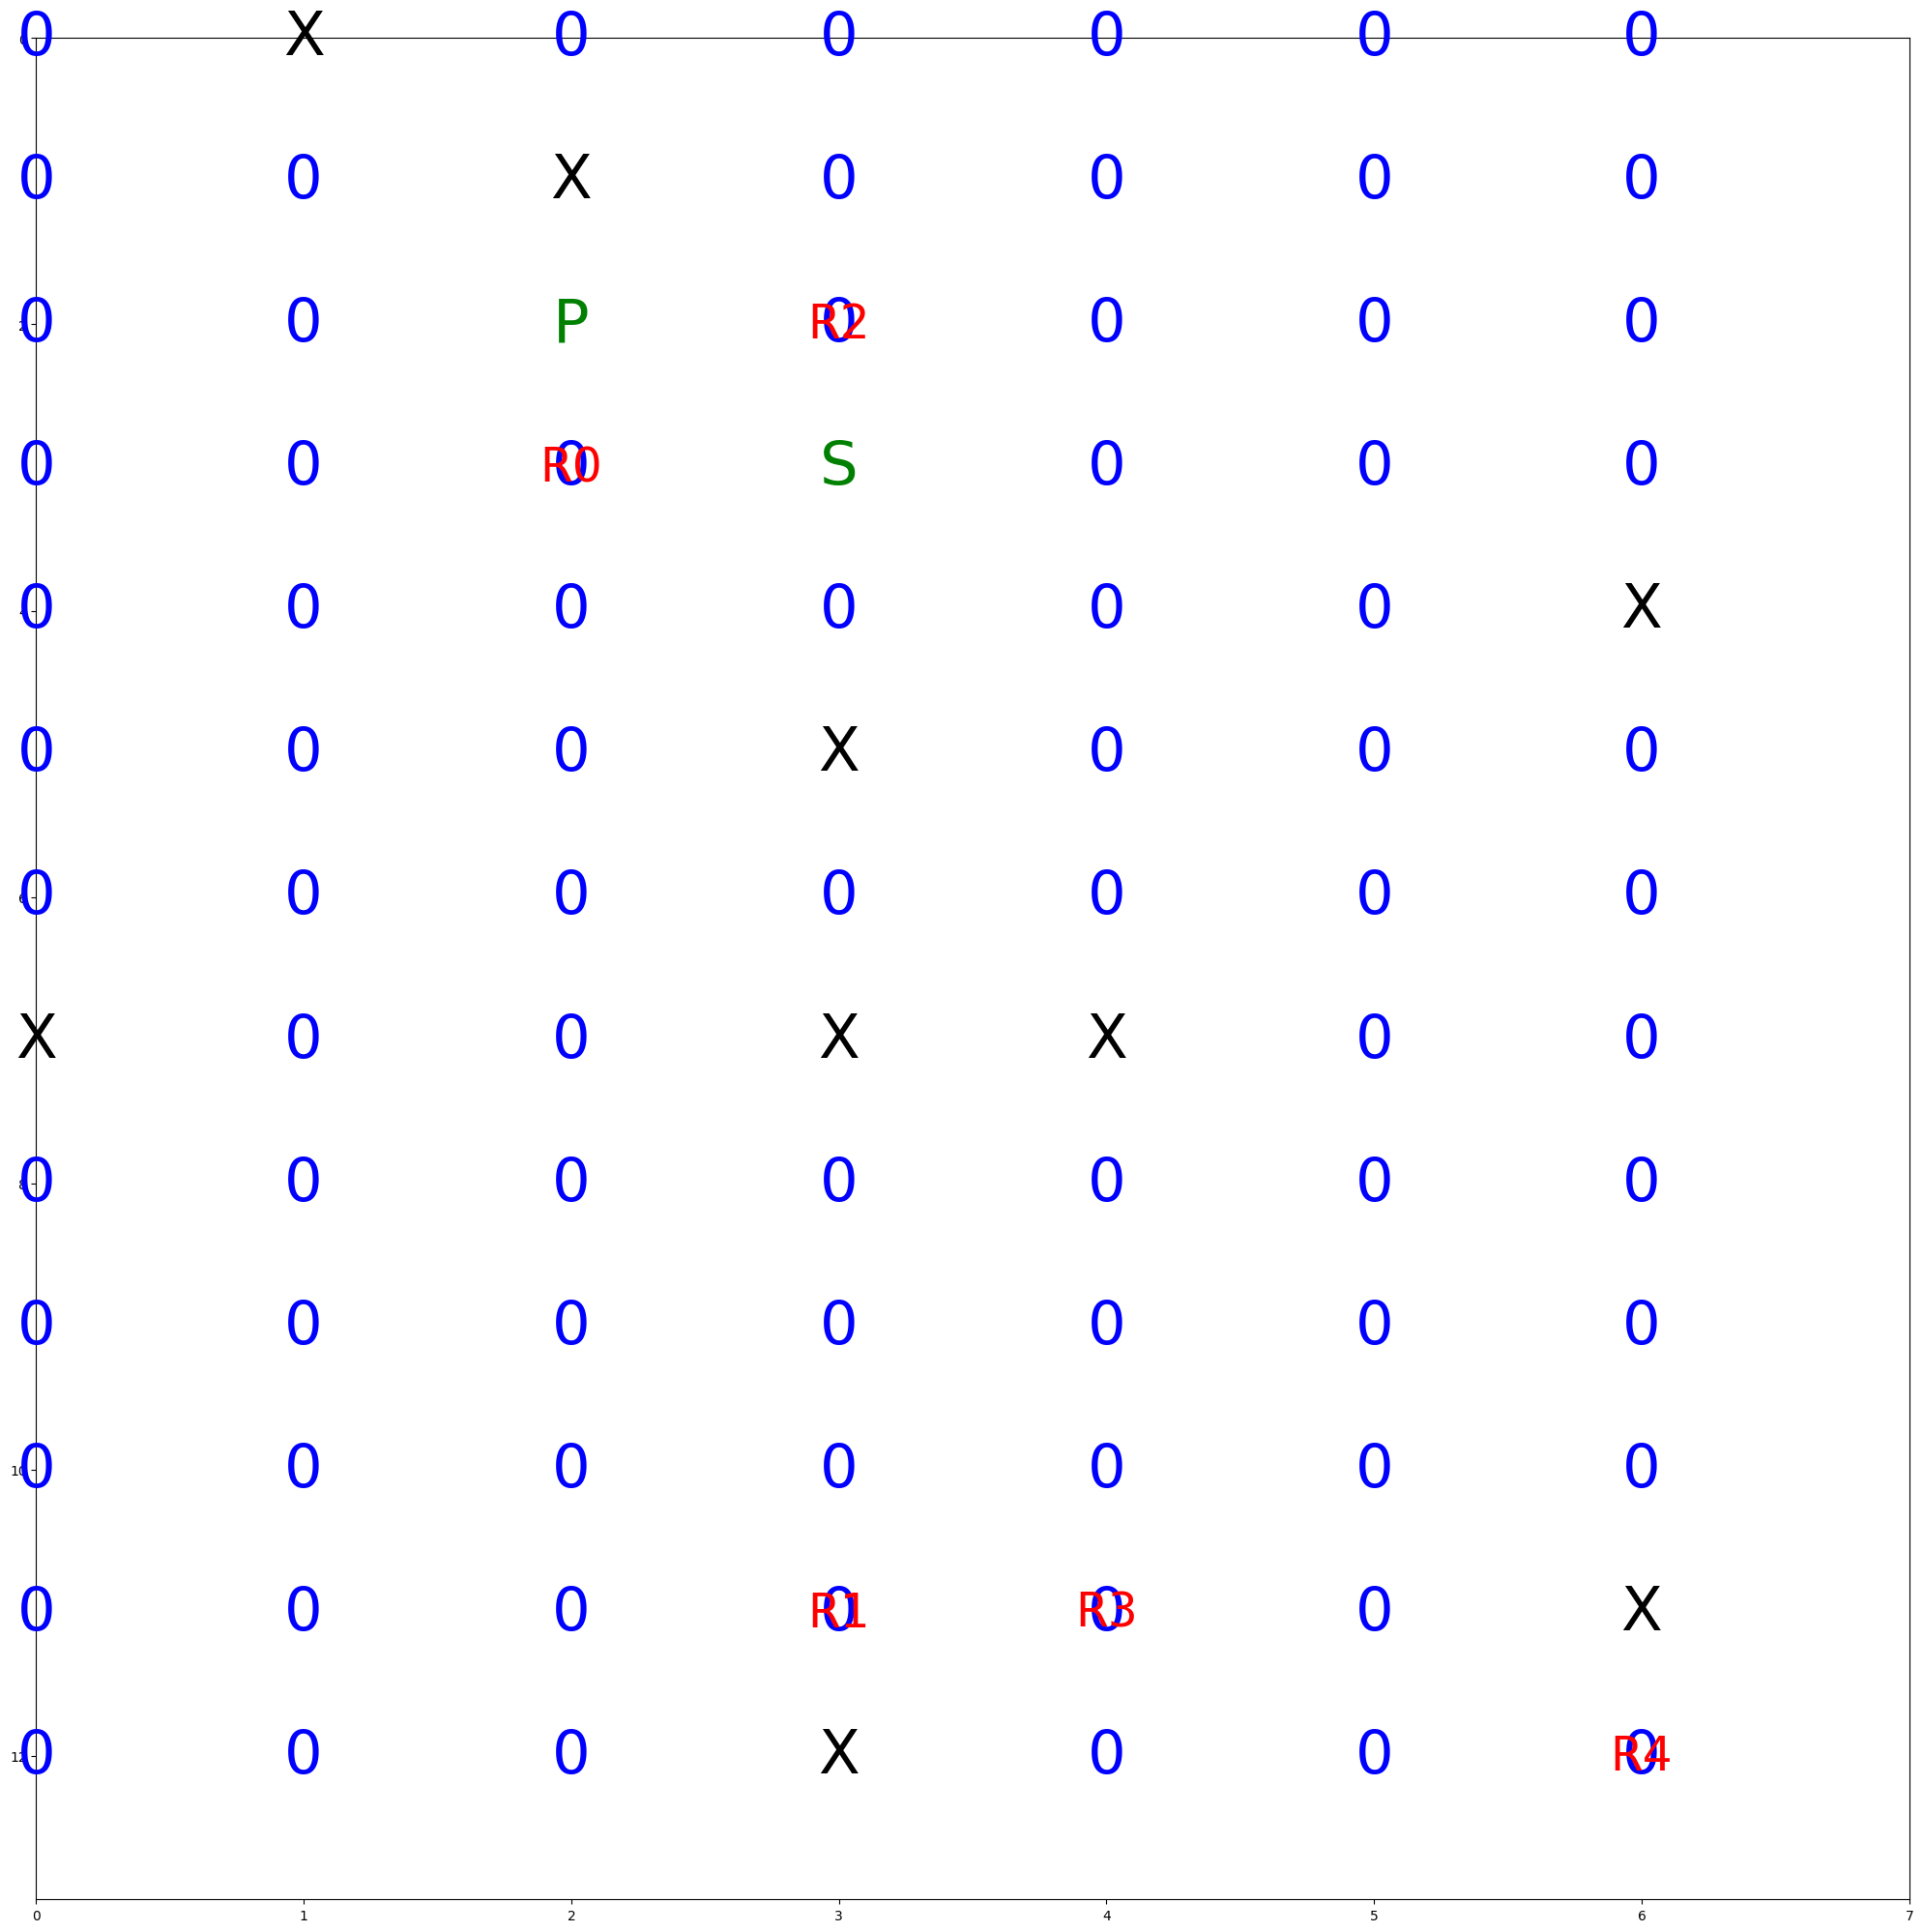

In [417]:
model = LimpiezaModel('mapa.txt')
ani = animation.FuncAnimation(model.fig, update, fargs=(model,), frames=200)
ani.save('animationPrueba.gif', writer='imagemagick', fps=10)
